In [1]:
import numpy as np
import torch
from torch import nn as nn
from torch.nn import functional as F
import torchvision.transforms as T
from torch.nn.utils import spectral_norm
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive

drive.mount('/content/drive')
print(torch.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1.10.0+cu111


In [3]:
class UNetDiscriminator(nn.Module):
    '''
    Parameters:
    num_in_ch: number of input channels (default = 3)
    num_feat: number of hidden features (default = 64)
    skip_connections: Use of skip connections (default = True)
    interpolate: method of upsampling (defalut = 'bilinear')

    '''

    def __init__(self, num_in_ch=3, num_feat=64, skip_connection=True, interpolate = 'bilinear'):
        super(UNetDiscriminator, self).__init__()
        self.skip_connection = skip_connection
        norm = spectral_norm
        self.interpolate = interpolate

        # the first convolution
        self.conv0 = nn.Conv2d(num_in_ch, num_feat, kernel_size=3, stride=1, padding=1)

        # downsample
        self.conv1 = norm(nn.Conv2d(num_feat, num_feat * 2, 4, 2, 1, bias=False))
        self.conv2 = norm(nn.Conv2d(num_feat * 2, num_feat * 4, 4, 2, 1, bias=False))
        self.conv3 = norm(nn.Conv2d(num_feat * 4, num_feat * 8, 4, 2, 1, bias=False))

        # upsample
        self.conv4 = norm(nn.Conv2d(num_feat * 8, num_feat * 4, 3, 1, 1, bias=False))
        self.conv5 = norm(nn.Conv2d(num_feat * 4, num_feat * 2, 3, 1, 1, bias=False))
        self.conv6 = norm(nn.Conv2d(num_feat * 2, num_feat, 3, 1, 1, bias=False))

        # Convolutions after downsample
        self.conv7 = norm(nn.Conv2d(num_feat, num_feat, 3, 1, 1, bias=False))
        self.conv8 = norm(nn.Conv2d(num_feat, num_feat, 3, 1, 1, bias=False))
        self.conv9 = nn.Conv2d(num_feat, 1, 3, 1, 1)

    def forward(self, x):
        # downsample
        x0 = F.leaky_relu(self.conv0(x), negative_slope=0.2, inplace=True)
        x1 = F.leaky_relu(self.conv1(x0), negative_slope=0.2, inplace=True)
        x2 = F.leaky_relu(self.conv2(x1), negative_slope=0.2, inplace=True)
        x3 = F.leaky_relu(self.conv3(x2), negative_slope=0.2, inplace=True)

        # upsample with bilinear interpolation
        x3 = F.interpolate(x3, scale_factor=2, mode=self.interpolate, align_corners=False)
        x4 = F.leaky_relu(self.conv4(x3), negative_slope=0.2, inplace=True)

        if self.skip_connection:
            x4 = x4 + x2
        x4 = F.interpolate(x4, scale_factor=2, mode=self.interpolate, align_corners=False)
        x5 = F.leaky_relu(self.conv5(x4), negative_slope=0.2, inplace=True)

        if self.skip_connection:
            x5 = x5 + x1
        x5 = F.interpolate(x5, scale_factor=2, mode=self.interpolate, align_corners=False)
        x6 = F.leaky_relu(self.conv6(x5), negative_slope=0.2, inplace=True)

        if self.skip_connection:
            x6 = x6 + x0

        # Convolutions after upsample
        out = F.leaky_relu(self.conv7(x6), negative_slope=0.2, inplace=True)
        out = F.leaky_relu(self.conv8(out), negative_slope=0.2, inplace=True)
        out = self.conv9(out)

        return out


**Unet-output test**

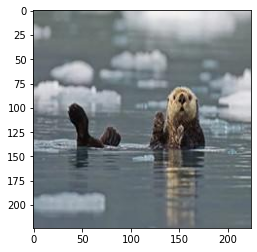

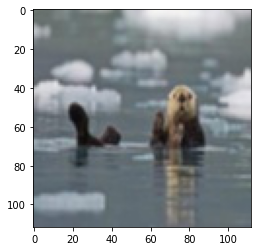

In [4]:
# import original image
img = Image.open('/content/drive/MyDrive/CS_523/Project/enhydra-lutris_24_0f938685.jpg')
plt.figure()
plt.imshow(img)
# import degraded test image
img_deg = Image.open('/content/drive/MyDrive/CS_523/Project/test_degraded.jpg')
plt.figure()
plt.imshow(img_deg)
# img to tensor
transform = T.ToTensor()
img_tensor = transform(img)
img_deg_tensor = transform(img_deg)

torch.Size([1, 3, 112, 112])
torch.Size([1, 3, 224, 224])


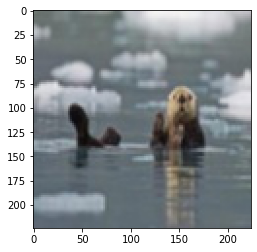

In [5]:
print(img_deg_tensor.unsqueeze(0).size())
test_interpolate = F.interpolate(input = img_deg_tensor.unsqueeze(0), scale_factor = 2)
print(test_interpolate.size())
to_pil = T.ToPILImage()
img_interpolate = to_pil(test_interpolate.squeeze(0))
plt.figure()
plt.imshow(img_interpolate)

img_interpolate_tensor = transform(img_interpolate)

In [17]:
# Load pretrained weights
model = UNetDiscriminator()
test = torch.load('/content/drive/MyDrive/CS_523/Project/RealESRGAN_x2plus_netD.pth')

model.load_state_dict(test['params'])

<All keys matched successfully>

torch.Size([224, 224])


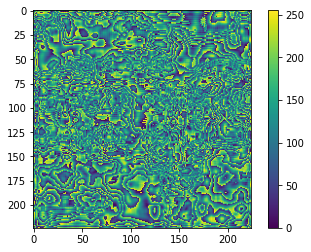

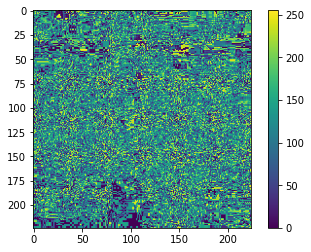

In [15]:
#Unet-output of interpolated image
output = model(img_interpolate_tensor.unsqueeze(0))
output_img = to_pil(output.squeeze(0))
plt.figure()
plt.imshow(output_img)
plt.colorbar()

#truth
scale = torch.mean(torch.div(img_tensor,img_interpolate_tensor)*256, dim = 0)
print(scale.size())
scale_img = to_pil(scale)
plt.figure()
plt.imshow(scale_img)
plt.colorbar()